In [1]:
import Le_Module.Utilities.FinUtils as fu
from Le_Module.Utilities.DataClasses import *
from Le_Module.PredictorsManagement import *
from Le_Module.StrategiesManagement import *
from Le_Module.PaperworkManagement import *
import keras
from keras import layers
import tensorflow as tf
from tinkoff.invest import CandleInterval, CandleInstrument, SubscriptionInterval, Client, InstrumentIdType, OrderType
import time
import matplotlib.pyplot as plt
import numpy as np

figi = 'BBG004S68B31'
token = '____'
budget = 100000
acc_id2 = '____'
acc_id1 = '____'

def sceduler(epoch, lr):
    if epoch < 200:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lrs0 = [layers.Dense(5, activation='LeakyReLU'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(64, activation='LeakyReLU'),
        layers.Dense(64, activation='LeakyReLU'),
        layers.Dense(1, activation='LeakyReLU'),]

lrs1 = [layers.LSTM(1024, input_shape=[11, 5], return_sequences=True, activation='LeakyReLU'),
        #layers.BatchNormalization(),
        layers.LSTM(1024, return_sequences=True, activation='LeakyReLU'),
        layers.Conv1D(64, kernel_size=2, strides=(2), padding='valid', activation='LeakyReLU'),
        layers.Conv1D(64, kernel_size=2, strides=(2), padding='valid', activation='LeakyReLU'),
        layers.Conv1D(32, kernel_size=2, strides=(2), padding='valid', activation='LeakyReLU'),
        layers.Dense(1, activation='relu')]

lrs2 = [layers.Dense(5, input_shape=[5, 11], activation='LeakyReLU'),
        layers.BatchNormalization(),
        layers.Conv1D(64, kernel_size=2, strides=(2), activation='sigmoid'),
        layers.Conv1D(64, kernel_size=2, strides=(2), activation='sigmoid'),
        layers.Flatten(),
        layers.Dense(64, activation='LeakyReLU'),
        layers.Dense(1, activation='LeakyReLU')]

input_len = 5
nepochs = 280

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, restore_best_weights=True)
lrscheduler = keras.callbacks.LearningRateScheduler(sceduler)

In [2]:
tha_ = fu.createdataset_tinkoff(fu.get_data_tinkoff(TOKEN=token, FIGI=figi, period=10, interval=CandleInterval.CANDLE_INTERVAL_5_MIN))

factory = Factories.AIPredictorFactory([tha_])

c:\Users\gelos\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\gelos\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [3]:
class my_condition(market_condition):
    def __call__(self, c: Candles) -> bool:
        return c.MAs[0] > c.Close

In [4]:
g = my_condition()
g(tha_)

False

In [5]:
samples, labels = fu.get_training_data(tha_, predictable='close', scope = 1)

In [6]:
p =  Predictors.PredictorParams(loss=keras.losses.Huber(),
                                optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                                structure=lrs2,
                                input_len=input_len,
                                scope=1,
                                output_len=1,
                                callbacks=[lrscheduler, earlystop],
                                epochs=nepochs//4,
                                validation_split=0.2,
                                training_verbose=True)
predictor = factory.construct_predictor(p)

Epoch 1/70

34/34 [==============================] - 1s 8ms/step - loss: 70.3887 - val_loss: 69.6119 - lr: 1.0000e-04
Epoch 2/70
34/34 [==============================] - 0s 3ms/step - loss: 69.3596 - val_loss: 68.5284 - lr: 1.0000e-04
Epoch 3/70
34/34 [==============================] - 0s 3ms/step - loss: 68.3191 - val_loss: 67.4203 - lr: 1.0000e-04
Epoch 4/70
34/34 [==============================] - 0s 3ms/step - loss: 67.1941 - val_loss: 66.2024 - lr: 1.0000e-04
Epoch 5/70
34/34 [==============================] - 0s 3ms/step - loss: 65.8904 - val_loss: 64.7957 - lr: 1.0000e-04
Epoch 6/70
34/34 [==============================] - 0s 3ms/step - loss: 64.4034 - val_loss: 63.1717 - lr: 1.0000e-04
Epoch 7/70
34/34 [==============================] - 0s 3ms/step - loss: 62.7123 - val_loss: 61.3240 - lr: 1.0000e-04
Epoch 8/70
34/34 [==============================] - 0s 3ms/step - loss: 60.7921 - val_loss: 59.2500 - lr: 1.0000e-04
Epoch 9/70
34/34 [==============================] - 0s 2ms/step

In [7]:
atr_rm = RiskManagers.ATRRiskManager()
s = sm.Squad(Predictors=[predictor], RiskManagers=[atr_rm])
provizor = sm.Provizor(s)
deci = DecidingModules.SimpleAIDecidingModule()
quant = QuantityControllers.AIQuantityControllerTPR1()
siggen = sm.SignalGenerator(deci, quant, provizor)

stratparams = sm.StrategyParams(SignalGenerator=siggen, TOKEN=token, FIGI = figi, Budget=budget, Backtest=True, Intervals=[CandleInterval.CANDLE_INTERVAL_5_MIN])

In [8]:
instruments = [CandleInstrument(figi=figi, interval=CandleInterval.CANDLE_INTERVAL_5_MIN)]

bridge = Bridges.CandlesBridge(token = token, acc_id = acc_id1, candle_instruments = instruments, waiting_close=True)

bot = sm.AutomatedStrategy(params=stratparams) 

In [9]:
for n in range(5, len(tha_.as_dataframe())//3):
    batch = DatabitsBatch(for_predictors=tha_[n-5 : n], for_risk_managers=tha_[n-5 : n])
    print(bot.decide(batch, transparency=True))

[DecisionsBatch(market=Decision(direction=False, amount=-1, type=0, price=-1), stop_loss=Decision(direction=False, amount=-1, type=1, price=72.64184089962517), take_profit=None), DatabitsBatch(for_predictors=Candles(Open=Indicator(name='open', values=array([72.95, 72.91, 72.9 , 72.87, 72.85]), span=[0]), Close=Indicator(name='close', values=array([72.91, 72.9 , 72.69, 72.87, 72.7 ]), span=[0]), High=Indicator(name='high', values=array([72.96, 72.91, 72.9 , 72.88, 72.86]), span=[0]), Low=Indicator(name='low', values=array([72.61, 72.61, 72.67, 72.68, 72.68]), span=[0]), Volume=Indicator(name='volume', values=array([ 62, 138,  48,  38,  50]), span=[0]), MAs=[Indicator(name='moving average', values=array([72.757 , 72.7485, 72.738 , 72.732 , 72.724 ]), span=[20]), Indicator(name='moving average', values=array([72.7198, 72.7166, 72.7138, 72.7156, 72.7138]), span=[50])], MACDhist=Indicator(name='MACD histogram', values=array([0.02434385, 0.02027212, 0.01620246, 0.01294867, 0.00907096]), span

In [10]:
max(bot.history['PnL'])

100000.11226

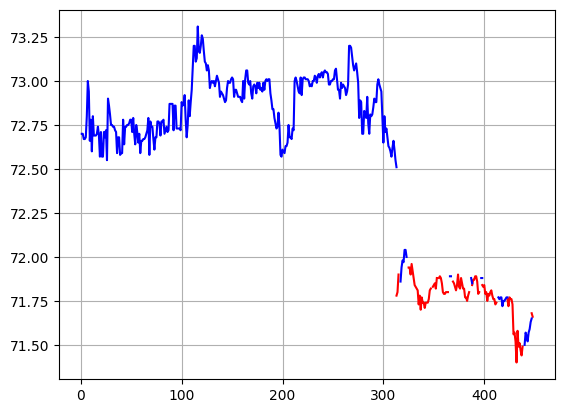

In [11]:
plt.plot(bot.history['Buy prices'][1:], 'r')
plt.plot(bot.history['Market sell prices'], 'b')
plt.grid(True)
plt.show()   #So here i stumbled upon a thought that just ai might be not so good for actual market decisions

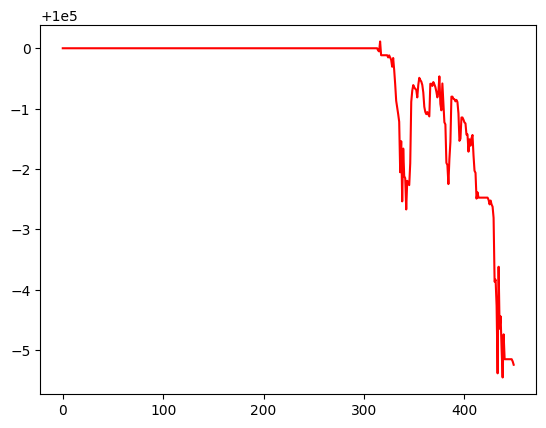

In [12]:
plt.plot(bot.history['PnL'], 'r') #So here i stumbled upon a thought that just ai might be not so good for actual market decisions

In [8]:
kinda_backtest_stats = []

for i in range(3):
    beginning = time.time()
    
    db_ = fu.createdataset_tinkoff(fu.get_data_tinkoff(token, FIGI=figi, period=1, interval=CandleInterval.CANDLE_INTERVAL_3_MIN))
    db = fu.DatabitsBatch(for_predictors=db_[-5:], for_trendviewers=db_[-5:], for_risk_managers=db_[-5:])
    thig = bot.decide(db, transparency=True)
    
    print(f'\nstep done at time: {time.time()}\n\n\n')
    
    end = time.time()
    print(thig)
    time.sleep(3*60 - (end - beginning))

c:\Users\gelos\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\gelos\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



step done at time: 1706208962.2334669



